<a href="https://colab.research.google.com/github/ElizabethB111/land-spatial-modeling/blob/main/2_forests_spatial_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup

In [ ]:
import os, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("Mixed precision policy:", mixed_precision.global_policy())

AUTOTUNE = tf.data.AUTOTUNE





TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision policy: <DTypePolicy "mixed_float16">


load EuroSAT from Hugging Face and build tensors

In [ ]:
!pip -q install datasets
from datasets import load_dataset

ds_hf = load_dataset("blanchon/EuroSAT_RGB")

NUM_CLASSES = ds_hf["train"].features["label"].num_classes
label_names = ds_hf["train"].features["label"].names
print("NUM_CLASSES:", NUM_CLASSES)
print("Classes:", label_names)

IMG_H, IMG_W = 64, 64
BATCH_SIZE = 256




NUM_CLASSES: 10
Classes: ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']


In [ ]:
def hf_to_tfds(hf_split, training: bool):
    def gen():
        for ex in hf_split:
            img = np.array(ex["image"], dtype=np.uint8)  # (64,64,3)
            y = int(ex["label"])
            yield img, y

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(IMG_H, IMG_W, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int32),
        ),
    )

    def preprocess(x, y):
        x = tf.cast(x, tf.float32) / 255.0            # normalize to [0,1]
        y = tf.one_hot(y, NUM_CLASSES)                # one-hot encoding
        return x, y

    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(20_000, seed=SEED, reshuffle_each_iteration=True)


    ds = ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
    return ds

train_ds = hf_to_tfds(ds_hf["train"], training=True)
val_ds   = hf_to_tfds(ds_hf["validation"], training=False)
test_ds  = hf_to_tfds(ds_hf["test"], training=False)

for xb, yb in train_ds.take(1):
    print("X:", xb.shape, xb.dtype, "| y:", yb.shape, yb.dtype)


X: (256, 64, 64, 3) <dtype: 'float32'> | y: (256, 10) <dtype: 'float32'>


In [ ]:
data_augment = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.12),
        layers.RandomZoom(0.10),
        layers.RandomContrast(0.10),
    ],
    name="augmentation",
)



In [ ]:
def build_functional_cnn(input_shape=(64, 64, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape, name="input")

    x = data_augment(inputs)

    # Block 1
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.20)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.35)(x)

    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32", name="probs")(x)

    return keras.Model(inputs, outputs, name="EuroSAT_Functional_CNN")

model = build_functional_cnn((IMG_H, IMG_W, 3), NUM_CLASSES)
model.summary()



Model: "EuroSAT_Functional_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 324,714 (1.24 MB)

 Trainable params: 323,306 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

compile and train


In [ ]:
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=[
        "accuracy",
        keras.metrics.TopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("best_cnn.keras", monitor="val_accuracy", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1,
)



Epoch 1/50
     64/Unknown 20s 39ms/step - accuracy: 0.5126 - loss: 1.5563 - top3_acc: 0.7813

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - accuracy: 0.5141 - loss: 1.5519 - top3_acc: 0.7828 - val_accuracy: 0.1044 - val_loss: 2.8911 - val_top3_acc: 0.3343 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7085 - loss: 1.0150 - top3_acc: 0.9407 - val_accuracy: 0.1044 - val_loss: 4.3440 - val_top3_acc: 0.3343 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7713 - loss: 0.8762 - top3_acc: 0.9597 - val_accuracy: 0.1044 - val_loss: 4.8912 - val_top3_acc: 0.3343 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8023 - loss: 0.7944 - top3_acc: 0.9702 - val_accuracy: 0.1102 - val_loss: 4.8413 - val_top3_acc: 0.3361 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8405 - loss: 0.7091 - top3_acc: 0.9773 - val_accuracy: 0.1246 - val_loss: 4.5611 - val_top3_acc: 0.3378 - learning_rate: 5.0000e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s

evaluate

In [ ]:
test_metrics = model.evaluate(test_ds, verbose=1)
print(dict(zip(model.metrics_names, test_metrics)))



22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.8406 - loss: 0.7144 - top3_acc: 0.9898
{'loss': 0.7925283312797546, 'compile_metrics': 0.8118518590927124}


In [ ]:
!pip -q install scikit-learn
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)

def preds_and_true(model, ds):
    y_true, y_pred = [], []
    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)
        y_true.append(np.argmax(yb.numpy(), axis=1))
        y_pred.append(np.argmax(probs, axis=1))
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true, y_pred = preds_and_true(model, test_ds)

bal_acc = balanced_accuracy_score(y_true, y_pred)
print("Balanced accuracy:", bal_acc)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=label_names))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix shape:", cm.shape)


Balanced accuracy: 0.8056154387993397

Classification report:
                       precision    recall  f1-score   support

          Annual Crop       0.96      0.84      0.90       596
               Forest       0.69      1.00      0.82       608
Herbaceous Vegetation       0.77      0.86      0.81       573
              Highway       0.94      0.85      0.89       496
 Industrial Buildings       0.99      0.44      0.60       501
              Pasture       0.88      0.77      0.82       396
       Permanent Crop       0.92      0.74      0.82       538
Residential Buildings       0.55      1.00      0.71       554
                River       0.98      0.80      0.88       529
              SeaLake       0.99      0.76      0.86       609

             accuracy                           0.81      5400
            macro avg       0.87      0.81      0.81      5400
         weighted avg       0.86      0.81      0.81      5400


Confusion matrix shape: (10, 10)


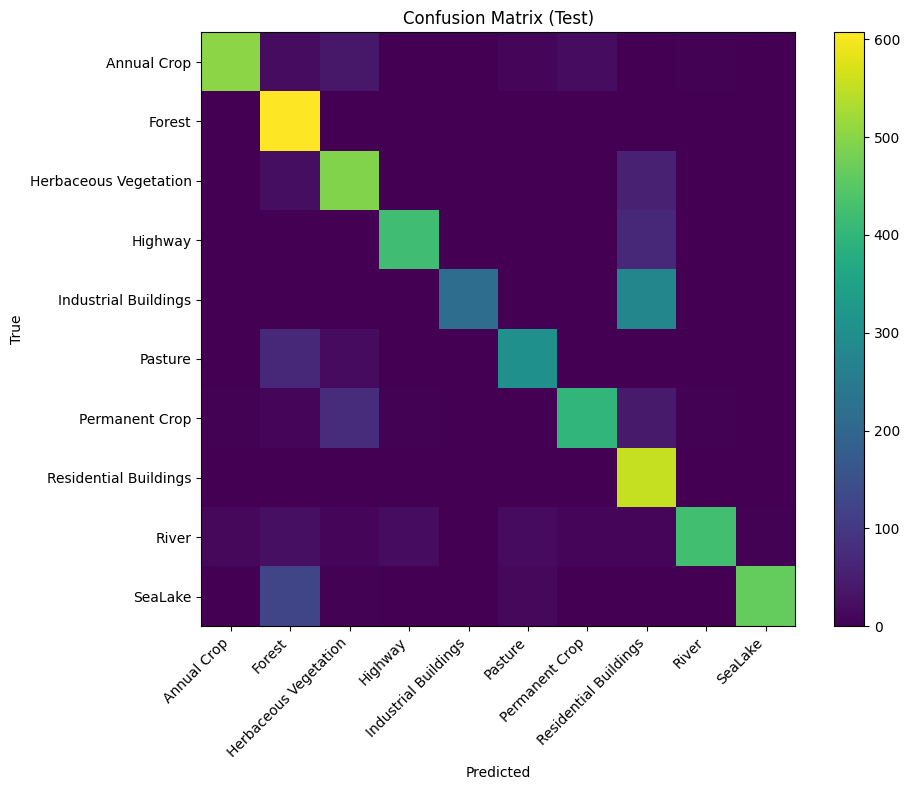

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, label_names, rotation=45, ha="right")
plt.yticks(ticks, label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
